In [224]:
import pyalex
from pyalex import Authors, Works
pyalex.config.email = "mail@example.com"

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300


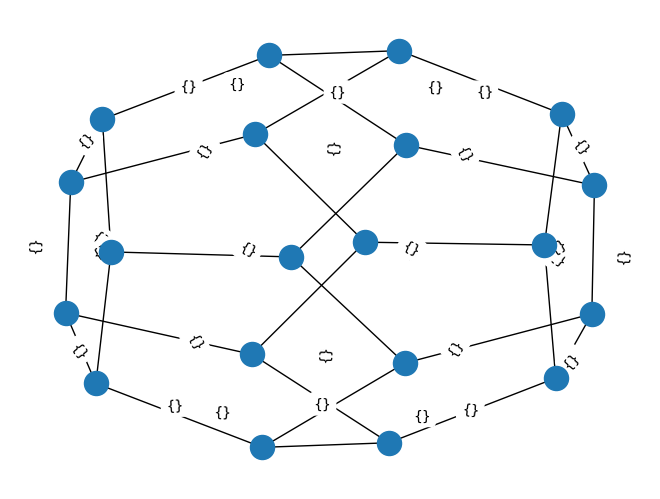

In [91]:
G = nx.dodecahedral_graph()
edge_labels = nx.draw_networkx_edge_labels(G, pos=nx.spring_layout(G))

0.5

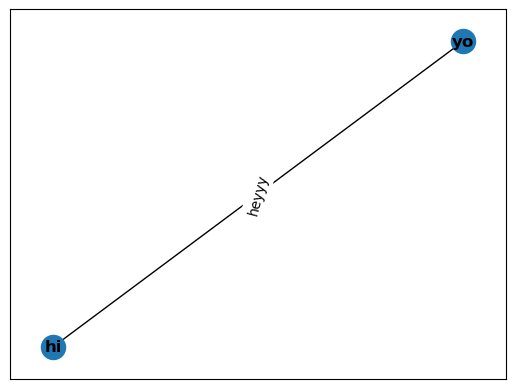

In [112]:
G = nx.Graph()
G.add_node(1, rand=0.5)
G.add_node(2)
G.add_edge(1, 2, times=[1, 2, 3])
G.edges
G.add_edge(1, 2, times=[4, 5, 6])
G.add_node(1)
G.edges[1,2]['times']
#G.edges[1][1]['times']

nx.draw_networkx(G, labels={1:'hi', 2:'yo'}, with_labels=True, font_weight='bold')
nx.draw_networkx_edge_labels(G, edge_labels={(1, 2): 'heyyy'}, pos=nx.spring_layout(G))

G.nodes[1]['rand']

In [59]:
[1, 3] in G.edges

False

In [328]:
def get_works_for_author(author_id):
    # TODO: has to be a better way to do this!
    pager = Works().filter(author={"id": author_id}).paginate(per_page=200)
    all_works = []
    for page in pager:
        for work in page:
            if work is not None and work['display_name'] is not None: # must exist and have a title? TODO: check this
                all_works.append(work)

    return all_works

def has_paper(author_id, paper_title):
    works = get_works_for_author(author_id) #Works().filter(author={"id": author_id}).get()

    for work in works:
        # compare work['title'] and paper_title case insensitively
        print("work: ", work)
        if work['display_name'].lower() == paper_title.lower():
            return True
    return False
        
def names_and_papers_to_author_objects(names, paper_titles):
    found_authors = []
    for name, paper_title in zip(names, paper_titles):
        # Find all authors with this name 
        authors = Authors().search_filter(display_name=name).get()
        print(f"Found {len(authors)} authors with name {name}")

        # for each author, go and find which has the paper
        authors_with_paper = []
        for author in authors:
            print("Examining author ", author['display_name'])
            if has_paper(author['id'], paper_title):
                authors_with_paper.append(author)
        # If it's > 1 for now throw an error
        if len(authors_with_paper) > 1:
            raise Exception(f"Found more than one author with name {name} and paper {paper_title}")
        elif len(authors_with_paper) == 0:
            raise Exception(f"Found no authors with name {name} and paper {paper_title}")
        else:
            author = authors_with_paper[0]
            print(f"Found author {author['display_name']} with paper {paper_title}, id is {author['id']}")
            found_authors.append(author)

    return found_authors
def author_to_collaborators_with_times(author):
    # Get all works by this author
    works = get_works_for_author(author['id']) # Works().filter(author={"id": author['id']}).get()
    collaborators = []
    collaborator_ids = []
    collaborator_to_times_dict = {}

    for work in works:
        # Get all authors on this work
        collaborators_on_work = [authorship['author'] for authorship in work['authorships']]
        print("For author ", author['display_name'], "on work ", work['display_name'], " with id: ", work['id'], " found collaborators ", [collaborator['display_name'] for collaborator in collaborators_on_work])


        for collaborator in collaborators_on_work:
            # skip this collaborator if its the author
            if collaborator['id'] == author['id']:
                continue
            
            # For each add them to our list of collaborators if they're not already there 
            if collaborator['id'] not in collaborator_ids:
                collaborators.append(collaborator)
                collaborator_ids.append(collaborator['id'])

            # Track times of collaboration
            # if no times are tracked yet, add a list with just the current date
            time_str = work['publication_year'] #work['publication_date']

            if collaborator['id'] not in collaborator_to_times_dict:
                collaborator_to_times_dict[collaborator['id']] = [time_str]
            else:
                # make sure not duplicating 
                if time_str not in collaborator_to_times_dict[collaborator['id']]:
                    collaborator_to_times_dict[collaborator['id']].append(time_str)

    return collaborators, collaborator_to_times_dict

def create_network_authors(authors):
    # Create your empty graph
    G = nx.Graph()
    
    # Find all collaborators for each author
    for author in authors:
        collaborators, collaborator_to_times_dict = author_to_collaborators_with_times(author)
        # Add each collaborator to the graph by their id
        
        # add the author
        G.add_node(author['id'], author=author)
        for collaborator in collaborators:
            G.add_node(collaborator['id'], author=collaborator) # will ignore repeat nodes

        # Add edges between each collaborator and the author
        # if they already exist make sure to just append to the list of times any non-duplicate times 
        for collaborator in collaborators:
            print("For author ", author['display_name'], " adding edge to collaborator ", collaborator['display_name'], " with id: ", collaborator['id'])

            author_id = author['id']
            collaborator_id = collaborator['id']
            if [author_id, collaborator_id] in G.edges:
                # Add any times that aren't already in the list
                print("adding times: ", collaborator_to_times_dict[collaborator_id])
                for time in collaborator_to_times_dict[collaborator_id]:
                    if time not in G.edges[author_id][collaborator_id]['times']:
                        G.edges[author_id][collaborator_id]['times'].append(time)
            else:
                G.add_edge(author['id'], collaborator['id'], times=collaborator_to_times_dict[collaborator['id']])
        
    return G
def create_network_names_papers(names, paper_titles):
    """ 
        Given a list of names and paper titles, use pyalex 
        to (i) find each author's unique id, (ii) find all 
        collaborators each author has had, (iii) connect them into a network
        with information in the edges about the dates of the papers they are
        co-authors on
    """
    # Get the author object associated with each name, paper_title pair
    authors = names_and_papers_to_author_objects(names, paper_titles)
    return create_network_authors(authors)

# names = ["Claire Tomlin"]
# paper_titles = ["A time-dependent Hamilton-Jacobi formulation of reachable sets for continuous dynamic games"]
# paper_titles = ["Maximum Likelihood Constraint Inference on Continuous State Spaces"]

# names = ["Duygu Tosun"]
# paper_titles = ["Longitudinal Measurements of Glucocerebrosidase activity in Parkinson's patients"]

names = ["Jack Gallant"]
paper_titles = ["Natural speech reveals the semantic maps that tile human cerebral cortex"]

# names = ["Christopher Strong",
#          "Kaylene Stocking"]
#         # "Jingqi Li",
#         #  "Jason Choi",
#         #  "Anand Siththaranjan"]
# paper_titles = ["Global optimization of objective functions represented by ReLU networks",
#                 "Linking vision and motion for self-supervised object-centric perception"]
#                 # "On the structural target controllability of undirected networks",
#                 # "Reinforcement learning for safety-critical control under model uncertainty, using control lyapunov functions and control barrier functions",
#                 # "Inferring neuronal ionic conductances from membrane potentials using cnns"]

authors = names_and_papers_to_author_objects(names, paper_titles)
temp_graph = create_network_authors(authors)

Found 2 authors with name Jack Gallant
Examining author  Jack L. Gallant
work:  {'id': 'https://openalex.org/W2007226897', 'doi': 'https://doi.org/10.1038/nature06713', 'title': 'Identifying natural images from human brain activity', 'display_name': 'Identifying natural images from human brain activity', 'publication_year': 2008, 'publication_date': '2008-03-01', 'ids': {'openalex': 'https://openalex.org/W2007226897', 'doi': 'https://doi.org/10.1038/nature06713', 'mag': '2007226897', 'pmid': 'https://pubmed.ncbi.nlm.nih.gov/18322462', 'pmcid': 'https://www.ncbi.nlm.nih.gov/pmc/articles/3556484'}, 'language': 'en', 'primary_location': {'is_oa': False, 'landing_page_url': 'https://doi.org/10.1038/nature06713', 'pdf_url': None, 'source': {'id': 'https://openalex.org/S137773608', 'display_name': 'Nature', 'issn_l': '0028-0836', 'issn': ['1476-4687', '0028-0836'], 'is_oa': False, 'is_in_doaj': False, 'host_organization': 'https://openalex.org/P4310319908', 'host_organization_name': 'Nature 

In [ ]:
https://openalex.org/A5045155646
https://openalex.org/A5045155646
https://openalex.org/A5045155646

In [298]:
Works()['https://openalex.org/W4385452024']

{'id': 'https://openalex.org/W4385452024',
 'doi': 'https://doi.org/10.23919/ecc57647.2023.10178160',
 'title': 'Stability and Robustness of a Hybrid Control Law for the Half-bridge Inverter',
 'display_name': 'Stability and Robustness of a Hybrid Control Law for the Half-bridge Inverter',
 'publication_year': 2023,
 'publication_date': '2023-06-13',
 'ids': {'openalex': 'https://openalex.org/W4385452024',
  'doi': 'https://doi.org/10.23919/ecc57647.2023.10178160'},
 'language': 'en',
 'primary_location': {'is_oa': False,
  'landing_page_url': 'https://doi.org/10.23919/ecc57647.2023.10178160',
  'pdf_url': None,
  'source': None,
  'license': None,
  'version': None,
  'is_accepted': False,
  'is_published': False},
 'type': 'article',
 'type_crossref': 'proceedings-article',
 'open_access': {'is_oa': True,
  'oa_status': 'green',
  'oa_url': 'https://arxiv.org/pdf/2204.07539',
  'any_repository_has_fulltext': True},
 'authorships': [{'author_position': 'first',
   'author': {'id': 'ht

In [317]:
# get all works by author with id https://openalex.org/A5045155646
works = Works().filter(author={"id": "A5045155646"}, ).get()
print(len(works))
for work in works:
    print(work['display_name'])
    print(work['title'])

25
A time-dependent Hamilton-Jacobi formulation of reachable sets for continuous dynamic games
A time-dependent Hamilton-Jacobi formulation of reachable sets for continuous dynamic games
Mobile Sensor Network Control Using Mutual Information Methods and Particle Filters
Mobile Sensor Network Control Using Mutual Information Methods and Particle Filters
Reducing Transient and Steady State Electricity Consumption in HVAC Using Learning-Based Model-Predictive Control
Reducing Transient and Steady State Electricity Consumption in HVAC Using Learning-Based Model-Predictive Control
Differentiation-state plasticity is a targetable resistance mechanism in basal-like breast cancer
Differentiation-state plasticity is a targetable resistance mechanism in basal-like breast cancer
Conflict resolution for air traffic management: a study in multiagent hybrid systems
Conflict resolution for air traffic management: a study in multiagent hybrid systems
Quadrotor Helicopter Flight Dynamics and Control: T

In [327]:
len(get_works_for_author("A5045155646"))

733

In [243]:
# create a list of the collaborators of each author using the edges of the graph
shell_lists = [[author['id']] for author in authors]
all_used = []
for i, author in enumerate(authors):
    for node in temp_graph[author['id']].keys():
        if node not in all_used:
            all_used.append(node)
            shell_lists[i].append(node)




(-12.0, 12.0)

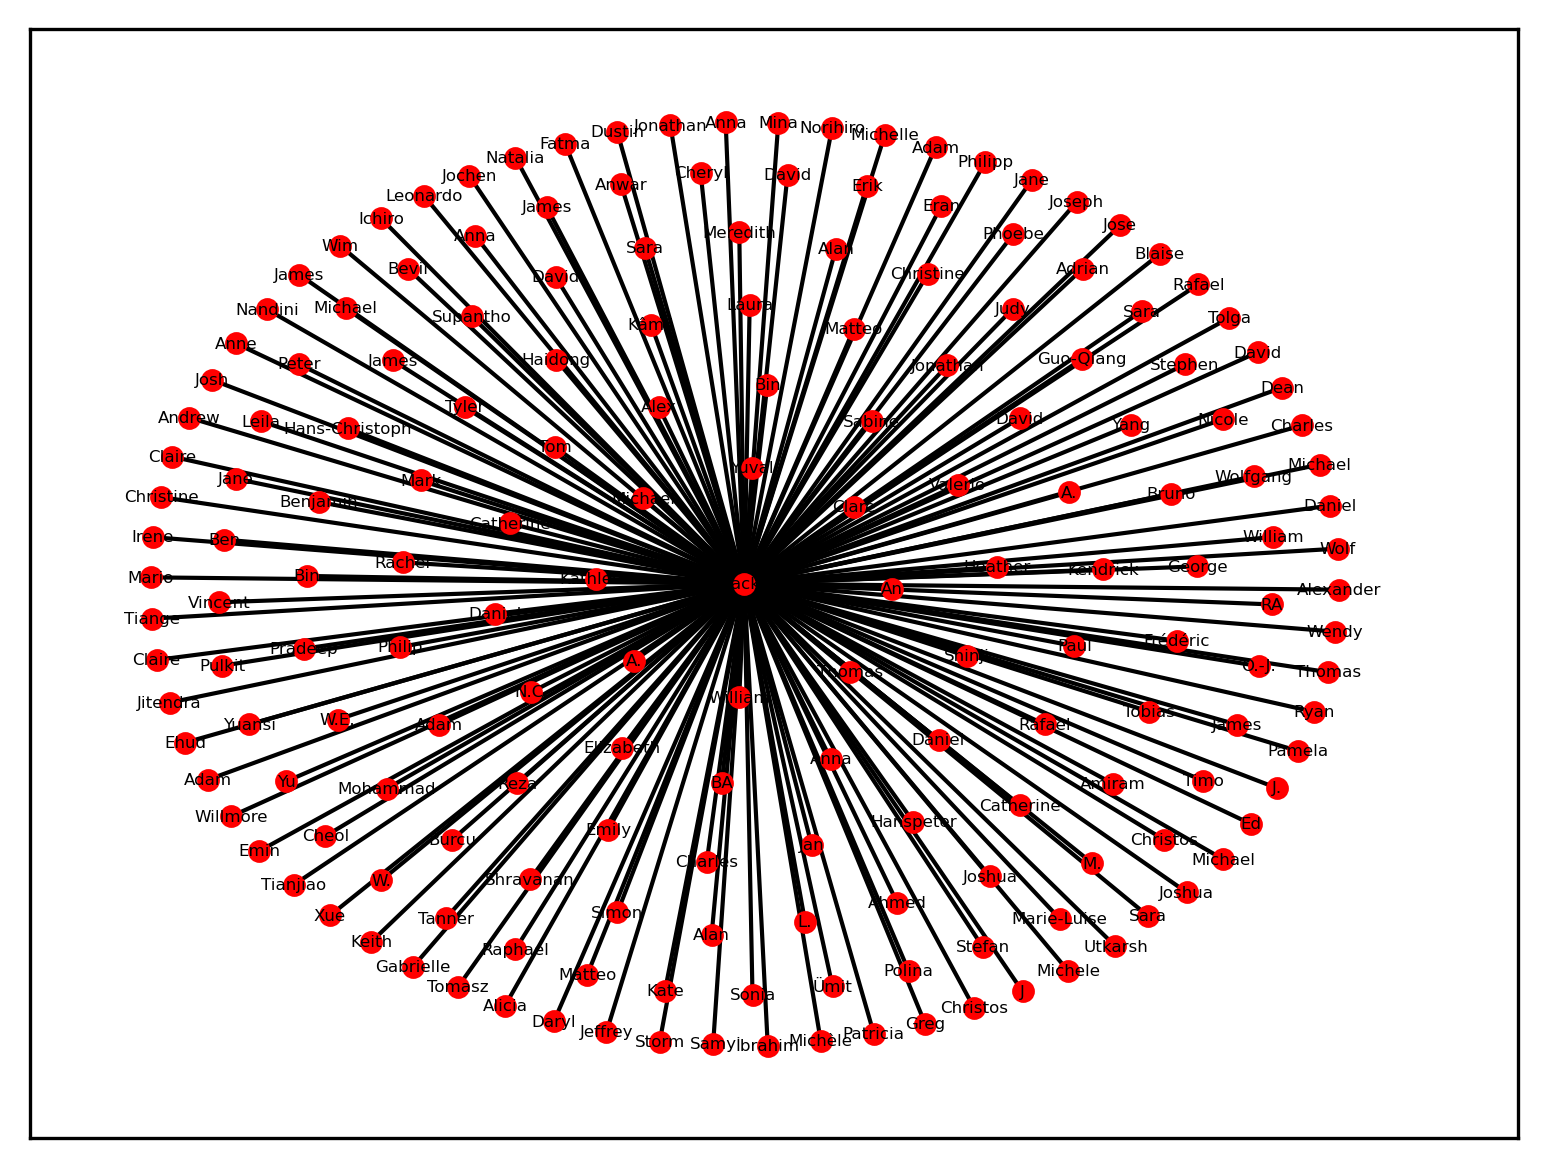

In [329]:
# construct the edge labels
node_labels = {node:temp_graph.nodes[node]['author']['display_name'] for node in temp_graph.nodes}
only_first_names = True
if only_first_names:
    node_labels = {node:node_labels[node].split()[0] for node in node_labels}

edge_labels = {edge: temp_graph.edges[edge[0], edge[1]]['times'] for edge in temp_graph.edges}
#nx.draw_networkx(temp_graph, with_labels=False)
#nx.draw_networkx_edge_labels(G, edge_labels=edge_labels, pos=nx.spring_layout(temp_graph))

#pos = nx.spring_layout(temp_graph, scale=10.0, k=3/np.sqrt(len(node_labels)))#, scale=10.0)
pos = nx.kamada_kawai_layout(temp_graph, scale=10.0)#, nlist=shell_lists)#, scale=10.0)
nx.draw_networkx(temp_graph, with_labels=True, labels=node_labels, pos=pos, font_size=4, node_size=20, node_color="red")
#nx.draw_networkx_edge_labels(temp_graph, edge_labels=edge_labels, pos=pos, font_size=4)

plt.xlim(-12, 13)
plt.ylim(-12, 12)

In [330]:
len(node_labels)

183

In [270]:
len(node_labels)

44

In [183]:
authors = Authors().search_filter(display_name="Jingqi Li").get()
for author in authors:
    print("----Author---")
    print(author['display_name'])
    print(author['id'])
    if author['last_known_institution'] is not None:
        print(author['last_known_institution']['display_name'])

    # get the works of this author
    works = Works().filter(author={"id":author["id"]}).get()
    print("----Works---")
    for work in works:
        print(work['title'])



----Author---
Jingqi Li
https://openalex.org/A5024100448
Guangdong Medical College
----Works---
Adaptive leader-following formation control with collision avoidance for a class of second-order nonlinear multi-agent systems
Dual active nanozyme-loaded MXene enables hyperthermia-enhanced tumor nanocatalytic therapy
Regulation of FADS2 transcription by SREBP-1 and PPAR-α influences LC-PUFA biosynthesis in fish
Forget less, count better: a domain-incremental self-distillation learning benchmark for lifelong crowd counting
Micro gas turbine: Developments, applications, and key technologies on components
Multi-walled carbon nanotubes for the immobilization of enzyme in glucose biosensors
Single‐Atom Nanozymes for Biomedical Applications: Recent Advances and Challenges
Fabrication of carbon nanotube field effect transistors by AC dielectrophoresis method
Manipulation of carbon nanotubes using AC dielectrophoresis
Thermal oxidation of Ni films for p-type thin-film transistors
Implosion of a bu

In [184]:
my_works = Works().filter(author={"id": "https://openalex.org/A5073548092"}).get()
for work in my_works:
    print(work['title'])

for authorship in my_works[0]['authorships']:
    print(authorship['author']['display_name'])

From Robot Learning To Robot Understanding: Leveraging Causal Graphical Models For Robotics
Kaylene Caswell Stocking
Alison Gopnik
Claire J. Tomlin
